# RESCUE
*Renewable Energy Salient Combined Uncertainty Estimator*

A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3.

Characteristics includes:
1. Weather, time and recent errors aware.
2. Correlation aware as solar,wind, and load errors are co-trained.
3. Produces multiple prediction intervals for expected error in netload forecasting
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast

Authors: Yuchi Sun, Vignesh Venugopal, Charles Gulian


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import cross_val

# 1. Data Ingress

Load in net load forecast error data. Preprocessing of the data is handled by a separate package.

TODO: Standardize the output for stability
TODO: Identify unfinished business.

TODO: Basic Data check and Assertion

Use `tf.data` to batch and shuffle the dataset:

In [16]:
PI_percentiles = np.array([0.5])

ckpts_dir = os.path.join(os.path.dirname(os.getcwd()),'ckpts','rescue_v1_1')
log_dir = os.path.join(os.path.dirname(os.getcwd()),'logs', 'rescue_v1_1')
trained_models_dir = os.path.join(os.path.dirname(os.getcwd()),'trained_models', 'rescue_v1_1')
data_dir = os.path.join(os.path.dirname(os.getcwd()),'data')
path_to_shuffled_indices = os.path.join(data_dir,"day_block_shuffled_indices_v1_1.npy")

batch_size = 64
max_epochs = 50
num_cv_folds = 10
optimizer_choice = 'adam'
E3_colors = [[3,78,110],[175,126,0],[175,34,0],[0,126,51],[175,93,0],[10,25,120]]
E3_colors = np.array(E3_colors)/255

In [3]:
# Read in input and output of the training and validation samples from data pipeline
input_trainval = pd.read_pickle(os.path.join(data_dir,'trainval_inputs.pkl'))
output_trainval = pd.read_pickle(os.path.join(data_dir,'trainval_output.pkl'))
datetimes_trainval = input_trainval.index
n_samples = input_trainval.shape[0]


# Call function
val_masks_all_folds = cross_val.get_CV_masks(datetimes_trainval, num_cv_folds, path_to_shuffled_indices)

Day block shuffling pre-determnined....
Done....
Creating train val masks for each fold....
Creating training and validation sets for fold 1 of 10
Creating training and validation sets for fold 2 of 10
Creating training and validation sets for fold 3 of 10
Creating training and validation sets for fold 4 of 10
Creating training and validation sets for fold 5 of 10
Creating training and validation sets for fold 6 of 10
Creating training and validation sets for fold 7 of 10
Creating training and validation sets for fold 8 of 10
Creating training and validation sets for fold 9 of 10
Creating training and validation sets for fold 10 of 10
Train and val masks are ready!


## 2. Model Definition
Define the stucture of the model from start to finish. Includes normalization layer, ANN model and pinball loss.

In [4]:
# class two_layer_ANN(tf.keras.Model):
#     '''
#     A two-layer ANN model with a pinball loss to produce prediction interval.
#     The model can take an arbitrary amounts of input. As a rule of thumb less than 100 input terms would be preferred.
#     The model's target/label should be the true value of the prediction whose upper/lower bound we are interested in. 
#     In our application, since we are interested in the range of forecast erros, the label should be the forecast error.
    
#     '''
#     def __init__(self):
#         super(two_layer_ANN, self).__init__()
#         self.d1 = tf.keras.layers.Dense(10, activation='relu')
#         self.d2 = tf.keras.layers.Dense(10, activation='relu')
#         self.d3 = tf.keras.layers.Dense(1)

#     def call(self, x):
#         x = self.d1(x)
#         x = self.d2(x)
#         x = self.d3(x)
#         return x

Build the ANN model with Pinball loss using the Keras [functional API](https://www.tensorflow.org/guide/keras#model_subclassing)
                                                                    

In [5]:
# Create a model that include the normalization layer
inputs = tf.keras.Input(shape=input_trainval.shape[1:])

# Create a Normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_inputs = normalizer(inputs)

# A two-layer ANN network for regression
dense1 = tf.keras.layers.Dense(10, activation='relu')
hidden1 = dense1(norm_inputs)
dense2 = tf.keras.layers.Dense(10, activation='relu')
hidden2 = dense2(hidden1)
dense3 = tf.keras.layers.Dense(1)
outputs = dense3(hidden2)

# define model from inputs to outputs
rescue_model = tf.keras.Model(inputs, outputs)

In [6]:
class PinballLoss(tf.keras.losses.Loss):
    def __init__(self, tau=0.5, name="pinball_loss"):
        super().__init__(name=name)
        self.tau = tau

    def call(self, y_true, y_pred):
        err = y_true - y_pred
        skewed_mse = tf.math.reduce_mean(tf.math.maximum(self.tau * err, (self.tau - 1) * err), axis=0)

        return skewed_mse


class CoverageProbability(tf.keras.metrics.Metric):
    def __init__(self, name = 'CP',**kwargs):
        super(CoverageProbability, self).__init__(name = name, **kwargs)
        self.coverage_probability = self.add_weight(name = 'CP_Var', initializer="zeros", dtype = tf.float64)
        self.cum_n_samples = self.add_weight(name = 'n_samples', initializer="zeros", dtype = tf.int32)
        self.cum_n_covered = self.add_weight(name = 'n_covered', initializer="zeros", dtype = tf.int32)
        
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.cum_n_samples.assign_add(tf.size(y_pred, out_type=tf.int32))
        self.cum_n_covered.assign_add(tf.math.count_nonzero(tf.math.less_equal(y_true,y_pred), dtype = tf.int32))
        self.coverage_probability.assign(tf.math.divide(self.cum_n_covered, self.cum_n_samples))

    def result(self):
        return self.coverage_probability

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.coverage_probability.assign(0.0)
    

# early stopping criteria is validation loss. 
# Min loss change of 1 in 2 epochs (patience)
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.5, patience=3 , verbose=1)

# we will overwrite the current checkpoint if and only if the `val_loss` score has improved.
# The saved model name will include the current epoch. and into the ckpts_dir folder
def get_cb_check_points(ckpts_dir, tau, fold_idx):
    # make sure models for different tau go to different directories
    ckpts_dir = os.path.join(ckpts_dir, "tau_{:.0%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(ckpts_dir):
        os.makedirs(ckpts_dir)
    cb_check_points = tf.keras.callbacks.ModelCheckpoint(filepath=ckpts_dir, save_best_only=True, monitor="val_loss", verbose=0)
    return cb_check_points

# the tensorboard callback allow us to visualize and observe training history in a pre-compiled tensorboard interface.
# Currrently not logging the histogram of activation and embedding layers 
# Write log per epoch.

def get_cb_tensor_board(log_dir, tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    log_dir = os.path.join(log_dir, "tau_{:.0%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    cb_tensor_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, embeddings_freq=0,  update_freq="epoch")  
    return cb_tensor_board

def save_rescue_model(trained_models_dir, model, tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    trained_models_dir = os.path.join(trained_models_dir, "tau_{:.0%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(trained_models_dir):
        os.makedirs(trained_models_dir)
    
    model.save(trained_models_dir)
    return None    


In [8]:
rescue_model_set = {}
history = {}

for tau in PI_percentiles:
    print("Training model for Prediction interval: {:.1%}".format(tau))
    for fold_idx in range(num_cv_folds):
        print("Cross Validation fold #", fold_idx+1)
        
        # Split into training and validation dataset based on the validation masks of this CV fold
        input_train, output_train = input_trainval[~val_masks_all_folds[fold_idx]], output_trainval[~val_masks_all_folds[fold_idx]]
        input_val, output_val = input_trainval[val_masks_all_folds[fold_idx]], output_trainval[val_masks_all_folds[fold_idx]]
        
        # cast to 'float32'
        input_train = input_train.values.astype('float32')
        output_train = output_train.values.astype('float32')
        input_val = input_val.values.astype('float32')
        output_val = output_val.values.astype('float32')

        # Transoform into tensorflow Dataset type for training
        train_ds = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(buffer_size= n_samples).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(buffer_size = n_samples).batch(batch_size)


        rescue_model_set[(tau, fold_idx)] = tf.keras.models.clone_model(rescue_model)
        rescue_model_set[(tau, fold_idx)].get_layer(index = 1).adapt(input_trainval.values) 
        rescue_model_set[(tau, fold_idx)].compile(loss = PinballLoss(tau = tau), 
                                                  metrics= [CoverageProbability()],optimizer=optimizer_choice)
        
        history[(tau, fold_idx)]= rescue_model_set[(tau, fold_idx)].fit(train_ds, validation_data=val_ds, epochs=max_epochs,
                                                                        callbacks=[cb_early_stopping, get_cb_check_points(ckpts_dir, tau, fold_idx), 
                                                                                   get_cb_tensor_board(log_dir, tau, fold_idx)])
        
        # Save the trained rescue model for each target percentile and fold
        save_rescue_model(trained_models_dir, rescue_model_set[(tau, fold_idx)], tau, fold_idx)


Training model for Prediction interval: 50.0%
Cross Validation fold # 1
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1394/1400 [============================>.] - ETA: 0s - loss: 124.8977 - CP: 0.5102WARNING:tensorflow:From C:\Users\yuchi\Anaconda3\envs\e3rescue\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\yuchi\PycharmProjects\RESCUE\ckpts\rescue_v1_1\tau_50%\fold_#0\assets
1400/1400 [==============================] - 3s 2ms/step - loss: 124.8862 - CP: 0.5102 - val_loss: 124.7393 - val_CP: 0.5150
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 118.9500 - CP: 0.5178 - val_loss: 121.9662 - val_CP: 0.5188
Epoch 3/50
1400/1400 [=============

KeyboardInterrupt: 

# 3. Visualization of training results

## 3.1 Tensorboard

In [8]:
# obtain quantile forecast at different quantile level
pred_trainval = pd.DataFrame(index = pd.to_datetime(datetimes_trainval.loc['T+1'], infer_datetime_format=True))

for PI in PI_percentiles:
    pred_trainval[PI] = rescue_model_set[(PI,0)].predict(input_trainval.values)


In [7]:
pred_trainval = pd.read_pickle(os.path.join(os.path.dirname(os.getcwd()),"output", "pred_trainval.pkl"))

## 3.1 Forecast uncertainty's relationship with input variables

### 3.1.1 Forecast uncertainty v.s. Solar production

In [32]:
def plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, input_var_name):
    
    assert 0.5 in pred_trainval.columns, "No median forecast found!"
    
    pred_trainval_groupedby_input = pred_trainval.groupby(input_var_discretized.values).mean()
    num_PI_pairs = (len(pred_trainval_groupedby_input.columns)-1)/2
    fig, axarr  = plt.subplots(2,1, sharex = True, gridspec_kw={"height_ratios":[1,1]})  
    
    for i,PI in enumerate(pred_trainval_groupedby_input.columns):
        if PI == 0.5:
            axarr[1].plot(pred_trainval_groupedby_input.index, pred_trainval_groupedby_input[0.5], 
                          label =  "Quantile = {:.1%}".format(0.5), color = E3_colors[1]) 
        elif PI<0.5:
            axarr[1].fill_between(pred_trainval_groupedby_input.index, pred_trainval_groupedby_input[PI], 
                                  pred_trainval_groupedby_input[1-PI], color =  1- (1-E3_colors[0])*(i+1)/(num_PI_pairs+1),
                                  label =  "Quantile: {:.1%} to  {:.1%}".format(PI, 1-PI))

    
    axarr[1].scatter(input_trainval["Solar_RTPD_Forecast_T+1"], output_trainval, color = E3_colors[2], alpha = 0.005)
    
    
    axarr[1].set_ylabel('Quantile of Forecast Err (MW)')
    axarr[1].legend(frameon = False, loc = 'center left', bbox_to_anchor = [1,0.5])

    for i,PI in enumerate(pred_trainval_groupedby_input.columns):
        if PI<0.5:
            label = "P{:.0f}".format(100*(1-2*PI))
            upward_reserve = np.maximum(pred_trainval_groupedby_input[1-PI],0)
            downward_reserve = np.minimum(pred_trainval_groupedby_input[PI],0)
            
            # obtain the expected width of each bar
            input_var_range = pred_trainval_groupedby_input.index
            bar_width = ((input_var_range[-1] - input_var_range[0])
                         /(input_var_range.size - 1)*0.8)
            
            axarr[0].bar(input_var_range, upward_reserve, color = 1- (1-E3_colors[0])*(i+1)/(num_PI_pairs+1),
                         width = bar_width, label = label+" Up Reserve")
            axarr[0].bar(input_var_range, downward_reserve,  color = 1- (1-E3_colors[1])*(i+1)/(num_PI_pairs+1),
                         width = bar_width, label = label+" Down Reserve")

    axarr[0].legend(frameon = False, loc = 'center left', bbox_to_anchor = [1,0.5])
    axarr[0].set_ylabel('Reserves (MW)')

    axarr[0].set_title('Forecast uncertainty v.s. '+ input_var_name)
    axarr[-1].set_xlabel(input_var_name)

    fig.set_size_inches(8,6)
    fig.tight_layout()
    fig.savefig(input_var_name +'.png')
    
    return fig, axarr

def discretize_var(input_var, n_bins = 50):
    input_var_bins = np.linspace(input_var.min(), input_var.max(), n_bins)
    input_var_labels = (input_var_bins[:-1] + input_var_bins[1:])/2 
    input_var_discretized =  pd.cut(input_var, bins = input_var_bins, precision = 0,
                                    labels = input_var_labels, include_lowest= True)
    
    return input_var_discretized

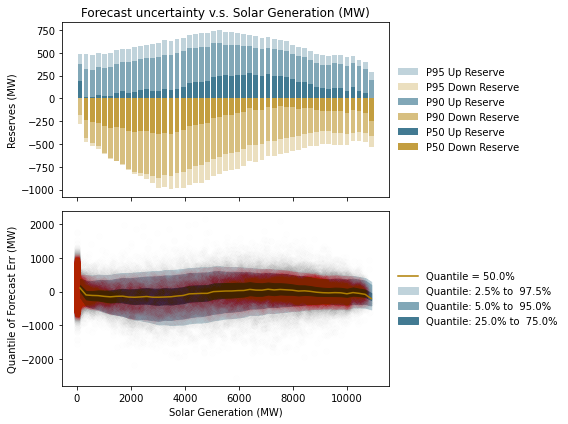

In [33]:
# Demonstrate the change in forecast uncertainty with respect to solar generation
input_var_discretized = discretize_var(input_trainval["Solar_RTPD_Forecast_T+1"])
fig, axarr = plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, "Solar Generation (MW)")

# # Demonstrate the change in forecast uncertainty with respect to solar generation
# input_var_discretized = discretize_var(input_trainval["Wind_RTPD_Forecast_T+1"])
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, "Wind Generation (MW)")

# # Demonstrate the change in forecast uncertainty with respect to solar generation
# input_var_discretized = discretize_var(input_trainval["Load_RTPD_Forecast_T+1"])
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, "Load (MW)")

# # Demonstrate the change in forecast uncertainty with respect to solar generation
# diurnal_var = pred_trainval.index.hour
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, diurnal_var, "Hour")

# # Demonstrate the change in forecast uncertainty with respect to solar generation
# seasonal_var = pred_trainval.index.month
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, seasonal_var, "Month")

# # Demonstrate the change in forecast uncertainty with respect to days
# input_var_discretized = discretize_var(input_trainval['Days_from_Start_Date_T+1'])
# input_var_discretized = pd.Timestamp('20170101') + input_var_discretized.astype('int')*pd.Timedelta('1D')
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, "Date of Observation")
# fig.autofmt_xdate()

No handles with labels found to put in legend.


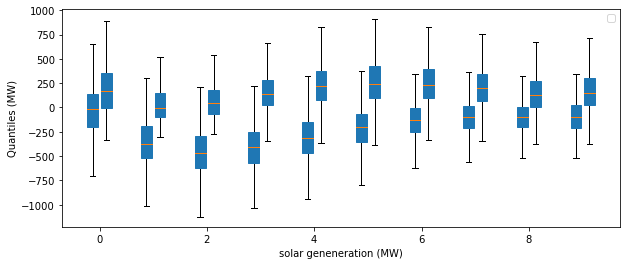

In [159]:
## Archived Code to produce Violin plot and Boxplot as quatile forecast respond to certain variable
# fig, ax = plt.subplots()

# for i,PI in enumerate([0.25,0.75]):
#     pred_trainval_gb = pred_trainval.groupby(solar_gen_bin.values)
#     pred_trainval_groupedby_solar = [pred_trainval_gb.get_group(cat)[PI] for cat in pred_trainval_gb.groups]
#     ax.boxplot(pred_trainval_groupedby_solar, showfliers= False, widths = 0.2, manage_ticks = False, patch_artist= True,
#                boxprops={"color":"C"+str(i)}, positions= np.arange(len(bin_edges)-1)+(PI-0.5)/2) 
        

# ax.set_ylabel('Quantiles (MW)')
# ax.set_xlabel('solar geneneration (MW)')
# ax.legend()

# fig.set_size_inches(10,4)

# fig, ax = plt.subplots()

# for i,PI in enumerate([0.25,0.75]):
#     for solar_bin in pred_trainval['solar_gen_bin'].unique():
#         violin_patches = ax.violinplot(pred_trainval.loc[pred_trainval['solar_gen_bin'] == solar_bin, PI],
#                                      positions = [solar_bin+(PI-0.5)/5], showmedians = False, showextrema = False)
        
#         for p in violin_patches['bodies']:
#             p.set_facecolor(colors[i])
#             p.set_alpha(0.3)

# ax.set_ylabel('Quantiles (MW)')
# ax.set_xlabel('solar geneneration (MW)')
# ax.legend()

# fig.set_size_inches(10,4)

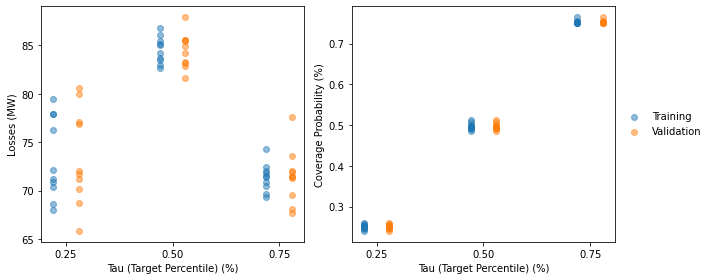

In [80]:
# Visualizing cross-validation performance and generalizability of the model
# reassemble the best performing model's loss
train_losses = pd.DataFrame(None, index = PI_percentiles)
val_losses = train_losses.copy()
train_cp = train_losses.copy()
val_cp = train_losses.copy()

for tau in PI_percentiles:
    for fold_idx in range(num_cv_folds):
        train_losses.loc[tau, fold_idx] = history[(tau, fold_idx)].history['loss'][-1]
        train_cp.loc[tau,fold_idx] = history[(tau, fold_idx)].history['CP'][-1]
        val_losses.loc[tau, fold_idx] = history[(tau, fold_idx)].history['val_loss'][-1]
        val_cp.loc[tau,fold_idx] = history[(tau, fold_idx)].history['val_CP'][-1]

# Visualization of the training process

fig, axarr = plt.subplots(1,2, sharex = True)
train_x_pos =np.expand_dims(np.array(PI_percentiles),1)*np.ones((1,num_cv_folds)) - 0.03
val_x_pos = np.expand_dims(np.array(PI_percentiles),1)*np.ones((1,num_cv_folds)) + 0.03

axarr[0].scatter(train_x_pos.ravel(), train_losses.values.ravel(),label = 'Training', alpha = 0.5)
axarr[0].scatter(val_x_pos.ravel(), val_losses.values.ravel(), label = 'Validation',alpha = 0.5)
axarr[0].set_xticks(PI_percentiles)
axarr[0].set_xlabel('Tau (Target Percentile) (%)')
axarr[0].set_ylabel('Losses (MW)')

axarr[1].scatter(train_x_pos.ravel(), train_cp.values.ravel(), label = 'Training' ,alpha = 0.5)
axarr[1].scatter(val_x_pos.ravel(), val_cp.values.ravel(), label = 'Validation',alpha = 0.5)
axarr[1].set_xticks(PI_percentiles)
axarr[1].set_xlabel('Tau (Target Percentile) (%)')
axarr[1].set_ylabel('Coverage Probability (%)')
axarr[1].axhline(PI_percentiles, dashes = [2,2], color = 'k')


axarr[1].legend(loc = 'center left', bbox_to_anchor = [1,0.5], frameon = False)
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('cross_validation_and_generalizability.png', bbox_inches = 'tight')

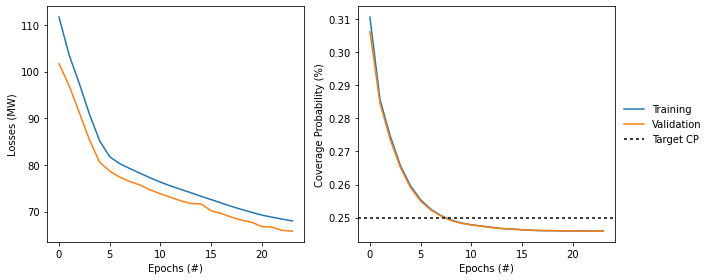

In [81]:
fig, axarr = plt.subplots(1,2, sharex = True)
history_eg = history[(0.25,0)].history

axarr[0].plot(history_eg['loss'],label = 'Training')
axarr[0].plot(history_eg['val_loss'], label = 'Validation')

axarr[0].set_xlabel('Epochs (#)')
axarr[0].set_ylabel('Losses (MW)')

axarr[1].plot(history_eg['CP'], label = 'Training')
axarr[1].plot(history_eg['val_CP'], label = 'Validation')
axarr[1].axhline(0.25, label = 'Target CP', dashes = [2,2], color = 'k')
axarr[1].set_xlabel('Epochs (#)')
axarr[1].set_ylabel('Coverage Probability (%)')

axarr[1].legend(loc = 'center left', bbox_to_anchor = [1,0.5], frameon = False)
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('training_history.png', bbox_inches = 'tight')

# 3. Deploying the model

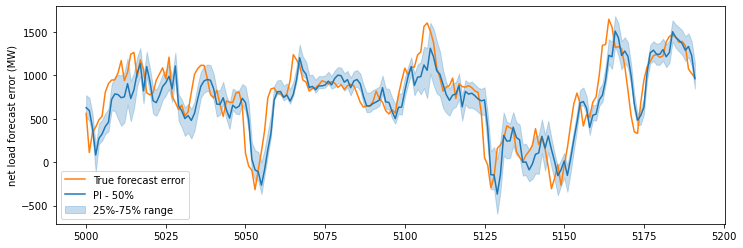

In [10]:
example_range = np.arange(5000,5192)
input_val_eg = input_val[example_range]
output_val_eg = output_val[example_range]

# confirm the PI percentiles are symmetrical
for PI in PI_percentiles:
    assert 1-PI in PI_percentiles, "Not all PI intervals are constructed symmetrically!"


fig,ax = plt.subplots()
ax.plot(example_range, output_val_eg, color = 'C1', label = 'True forecast error')

# plot median forecast if it is being produced
if 0.5 in PI_percentiles:
    ax.plot(example_range, rescue_model_set[0.5].predict(input_val_eg), color = 'C0', label = 'PI - 50%')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)),
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)),
                        color = 'C0', alpha = PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))

ax.set_ylabel("net load forecast error (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

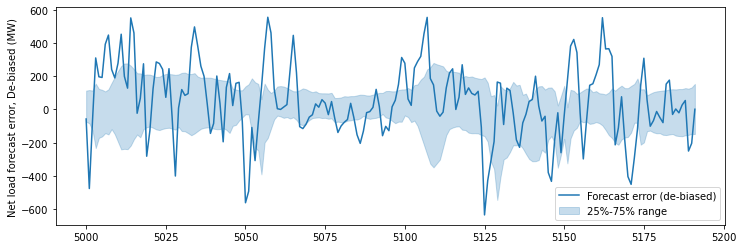

In [10]:
fig,ax = plt.subplots()
inherent_bias_eg = np.squeeze(rescue_model_set[0.5].predict(input_val[example_range]))

ax.plot(example_range, np.squeeze(output_val_eg) - inherent_bias_eg, label = 'Forecast error (de-biased)')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)) - inherent_bias_eg,
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)) - inherent_bias_eg,
                        color = 'C0', alpha =PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))


ax.set_ylabel("Net load forecast error, De-biased (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

Choose an optimizer and loss function for training: 

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [7]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

Use `tf.GradientTape` to train the model:

Test the model:

In [9]:
@tf.function
def train_step(inputs, outputs, model, loss_fn):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(inputs, training=True)
        loss = loss_fn(outputs, predictions)
    gradients = tape.gradient(loss, rescue.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rescue.trainable_variables))

    train_loss(loss)
    #train_accuracy(outputs, predictions)


@tf.function
def test_step(inputs, outputs, model, loss_fn):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = rescue(inputs, training=False)
    t_loss = loss_object(outputs, predictions)

    test_loss(t_loss)
    #test_accuracy(outputs, predictions)

In [10]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   #train_accuracy.reset_states()
#   test_loss.reset_states()
#   #test_accuracy.reset_states()

#   for inputs, outputs in train_ds:
#     train_step(inputs, outputs)

#   for test_inputs, test_outputs in test_ds:
#     test_step(test_inputs, test_outputs)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result()}, '
#     #f'Accuracy: {train_accuracy.result() * 100}, '
#     f'Test Loss: {test_loss.result()}, '
#     #f'Test Accuracy: {test_accuracy.result() * 100}'
#   )

Epoch 1, Loss: nan, Test Loss: nan, 
Epoch 2, Loss: nan, Test Loss: nan, 
Epoch 3, Loss: nan, Test Loss: nan, 
Epoch 4, Loss: nan, Test Loss: nan, 
Epoch 5, Loss: nan, Test Loss: nan, 
